In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from numpy.lib import recfunctions as rfn
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

Завдання №1. Завантанження та клінінг даних

In [265]:
# === pandas ===
start = time.time()
df = pd.read_csv("AirQualityUCI.csv", sep=';', decimal=',', header=0)
df = df.iloc[:, :-2] 
df = df[~df.isnull().all(axis=1)]  
df.replace(-200, np.nan, inplace=True) 
df.drop(columns=['NMHC(GT)'], inplace=True)  

df = df.infer_objects()  
df.fillna(df.median(numeric_only=True), inplace=True)
end = time.time() - start
print(f"=== pandas === {end:.4f} с")

# === numpy ===
with open("AirQualityUCI.csv", "r", encoding="latin1") as f:
    content = f.read().replace(",", ".")
with open("AirQuality_clean.csv", "w", encoding="latin1") as f:
    f.write(content)

start = time.time()
types = [
    ("Date", "U10"),
    ("Time", "U8"),
    ("CO(GT)", "f8"),
    ("PT08.S1(CO)", "f8"),
    ("NMHC(GT)", "f8"),
    ("C6H6(GT)", "f8"),
    ("PT08.S2(NMHC)", "f8"),
    ("NOx(GT)", "f8"),
    ("PT08.S3(NOx)", "f8"),
    ("NO2(GT)", "f8"),
    ("PT08.S4(NO2)", "f8"),
    ("PT08.S5(O3)", "f8"),
    ("T", "f8"),
    ("RH", "f8"),
    ("AH", "f8"),
   ]

arr = np.genfromtxt(
    "AirQuality_clean.csv", delimiter=";", dtype=types, names=True, encoding="utf-8"
)

for col in arr.dtype.names[2:]:
    arr[col][arr[col] == -200.0] = np.nan

num_cols = arr.dtype.names[2:]
mask = ~np.all([np.isnan(arr[col]) for col in num_cols], axis=0)
arr = arr[mask]

arr = rfn.drop_fields(arr, "NMHCGT")

for col in arr.dtype.names[2:]:
    median = np.nanmedian(arr[col])
    arr[col][np.isnan(arr[col])] = median

end = time.time() - start
print(f"=== numpy === {end:.4f} с")



=== pandas === 0.0295 с
=== numpy === 0.0741 с


In [266]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [267]:
arr

array([('10/03/2004', '18.00.00', 2.6, 1360., 11.9, 1046., 166., 1056., 113., 1692., 1268., 13.6, 48.9, 0.7578),
       ('10/03/2004', '19.00.00', 2. , 1292.,  9.4,  955., 103., 1174.,  92., 1559.,  972., 13.3, 47.7, 0.7255),
       ('10/03/2004', '20.00.00', 2.2, 1402.,  9. ,  939., 131., 1140., 114., 1555., 1074., 11.9, 54. , 0.7502),
       ...,
       ('04/04/2005', '12.00.00', 2.4, 1142., 12.4, 1063., 293.,  603., 175., 1241., 1092., 26.9, 18.3, 0.6406),
       ('04/04/2005', '13.00.00', 2.1, 1003.,  9.5,  961., 235.,  702., 156., 1041.,  770., 28.3, 13.5, 0.5139),
       ('04/04/2005', '14.00.00', 2.2, 1071., 11.9, 1047., 265.,  654., 168., 1129.,  816., 28.5, 13.1, 0.5028)],
      shape=(9326,), dtype=[('Date', '<U10'), ('Time', '<U8'), ('COGT', '<f8'), ('PT08S1CO', '<f8'), ('C6H6GT', '<f8'), ('PT08S2NMHC', '<f8'), ('NOxGT', '<f8'), ('PT08S3NOx', '<f8'), ('NO2GT', '<f8'), ('PT08S4NO2', '<f8'), ('PT08S5O3', '<f8'), ('T', '<f8'), ('RH', '<f8'), ('AH', '<f8')])

Завдання №2. Нормалізація даних

In [268]:
# === pandas ===
df_norm = df.copy()  
start = time.time()
for col in df.columns[2:]:
    min_val = df_norm[col].min()
    max_val = df_norm[col].max()
    df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
end = time.time() - start
    
print(f"=== pandas === {end:.4f} с")

# === numpy ===
arr_norm = arr.copy()  
start = time.time()
for col in arr_norm.dtype.names[2:]:
    a = arr_norm[col]
    min_val = np.min(a)
    max_val = np.max(a)
    arr_norm[col] = (a - min_val) / (max_val - min_val)
end = time.time() - start


print(f"=== numpy === {end:.4f} с")


=== pandas === 0.0070 с
=== numpy === 0.0019 с


In [269]:
df_norm.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066
1,10/03/2004,19.00.00,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282
2,10/03/2004,20.00.00,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352
3,10/03/2004,21.00.00,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190
4,10/03/2004,22.00.00,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216


In [270]:
arr_norm

array([('10/03/2004', '18.00.00', 0.21186441, 0.51184494, 0.18553459, 0.36209721, 0.11103588, 0.31088522, 0.32840237, 0.51303957, 0.45482189, 0.33333333, 0.49937107, 0.28006646),
       ('10/03/2004', '19.00.00', 0.16101695, 0.46302943, 0.14622642, 0.3123976 , 0.06838186, 0.36086404, 0.26627219, 0.45323741, 0.32623805, 0.32688172, 0.48427673, 0.26428187),
       ('10/03/2004', '20.00.00', 0.1779661 , 0.54199569, 0.13993711, 0.3036592 , 0.0873392 , 0.34646336, 0.33136095, 0.45143885, 0.37054735, 0.29677419, 0.56352201, 0.27635244),
       ...,
       ('04/04/2005', '12.00.00', 0.19491525, 0.35534817, 0.19339623, 0.37138176, 0.19702099, 0.11901737, 0.51183432, 0.3102518 , 0.37836664, 0.61935484, 0.11446541, 0.22279236),
       ('04/04/2005', '13.00.00', 0.16949153, 0.25556353, 0.14779874, 0.31567449, 0.1577522 , 0.16094875, 0.4556213 , 0.22032374, 0.23848827, 0.64946237, 0.05408805, 0.16087573),
       ('04/04/2005', '14.00.00', 0.1779661 , 0.30437904, 0.18553459, 0.36264336, 0.17806364,

Завдання №3. Гістограма по одному із атрибутів та з діапазоном значень

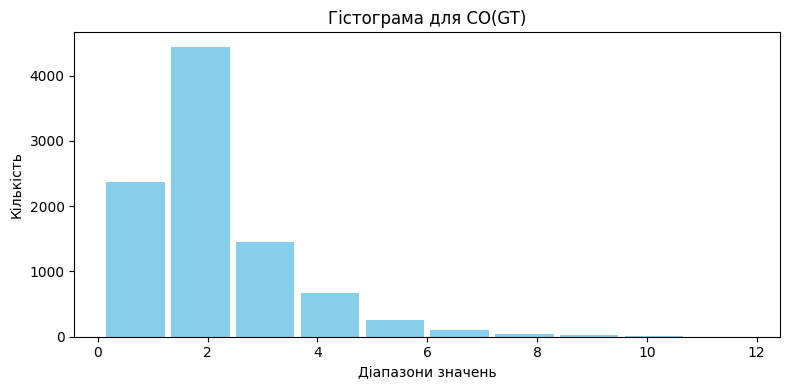

0.1287 c


In [271]:
start = time.time()
plt.figure(figsize=(8, 4))
plt.hist(df['CO(GT)'], bins=10, color='skyblue', rwidth=0.9)
plt.title("Гістограма для CO(GT)")
plt.xlabel("Діапазони значень")
plt.ylabel("Кількість")
plt.tight_layout()
plt.show()

end = time.time()
print(f"{end - start:.4f} c")


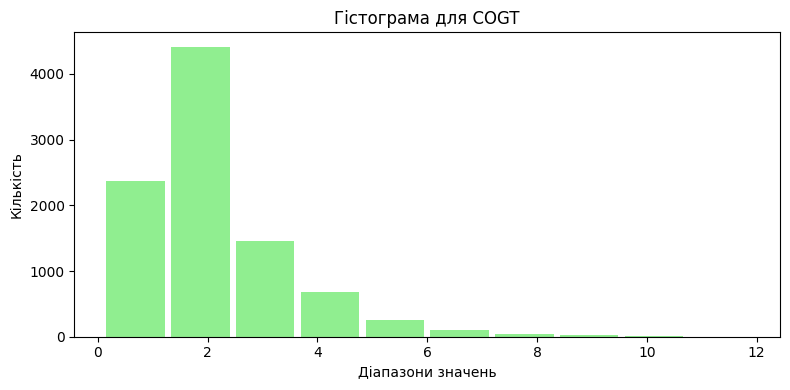

0.1337 c


In [272]:
start = time.time()
plt.figure(figsize=(8, 4))
plt.hist(arr['COGT'], bins=10, color='lightgreen', rwidth=0.9)
plt.title("Гістограма для COGT")
plt.xlabel("Діапазони значень")
plt.ylabel("Кількість")
plt.tight_layout()
plt.show()

end = time.time()
print(f"{end - start:.4f} c")


Завдання №4. Графік залежності одного integer атрибута від іншого.

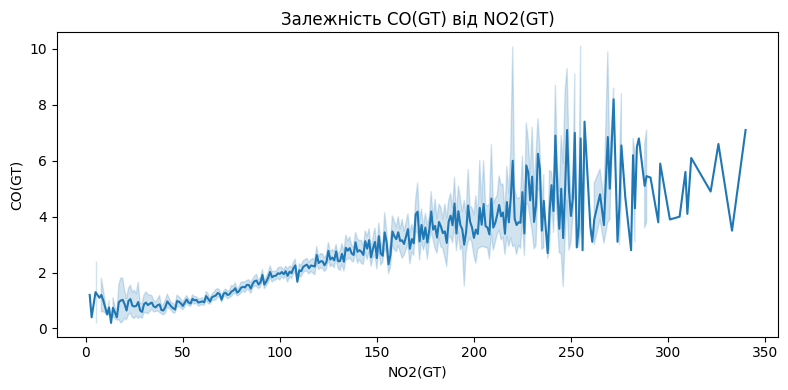

5.0177 c


In [273]:
start = time.time()
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='NO2(GT)', y='CO(GT)')
plt.title("Залежність CO(GT) від NO2(GT)")
plt.xlabel('NO2(GT)')
plt.ylabel('CO(GT)')
plt.tight_layout()
plt.show()

end = time.time()
print(f"{end - start:.4f} c")


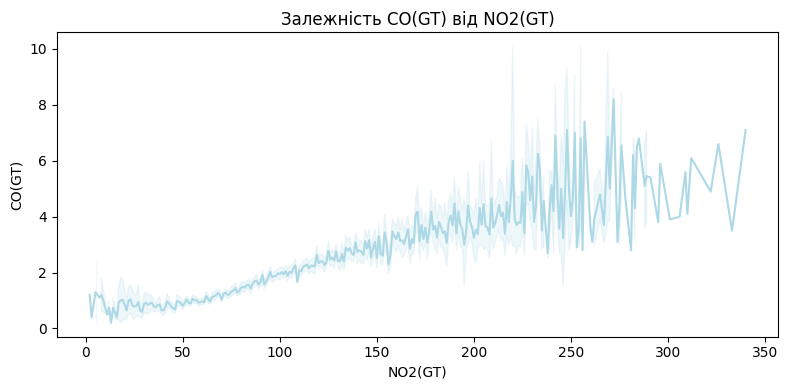

4.9354 с


In [274]:
start = time.time()
plt.figure(figsize=(8, 4))
sns.lineplot(x=arr['NO2GT'], y=arr['COGT'], color="lightblue")
plt.title(f"Залежність CO(GT) від NO2(GT)")
plt.xlabel('NO2(GT)')
plt.ylabel('CO(GT)')
plt.tight_layout()
plt.show()

end = time.time()
print(f"{end - start:.4f} с")


Завдання №5. Підрахунок коефіцієнтів Пірсона та Спірмена для двох integer атрибутів

In [275]:
start = time.time()
pearson_pandas, _ = pearsonr(df['NO2(GT)'], df['CO(GT)' ])
end = time.time() - start
print(f"== pandas ==\nПірсон: {pearson_pandas:.4f} ({end:.6f} c)")

start = time.time()
spearman_pandas, _ = spearmanr(df['NO2(GT)'], df['CO(GT)' ])
end = time.time() - start
print(f"Спірмен: {spearman_pandas:.4f} ({end:.6f} c)\n")

# == numpy ==
start = time.time()
pearson_numpy, _ = pearsonr(arr['NO2GT'], arr['COGT'])
end = time.time() - start
print(f"== numpy ==\nПірсон: {pearson_numpy:.4f} ({end:.6f} c)")

start = time.time()
spearman_numpy, _ = spearmanr(arr['NO2GT'], arr['COGT'])
end = time.time() - start
print(f"Спірмена: {spearman_numpy:.4f} ({end:.6f} c)")


== pandas ==
Пірсон: 0.6560 (0.001613 c)
Спірмен: 0.6692 (0.001976 c)

== numpy ==
Пірсон: 0.6560 (0.000872 c)
Спірмена: 0.6695 (0.001587 c)


Завдання №6. One Hot Encoding categorical атрибуту Time

In [276]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# == pandas ==
start = time.time()
encoded_pandas = encoder.fit_transform(df[['Time']])
df_encoded = pd.DataFrame(encoded_pandas, columns=encoder.get_feature_names_out(['Time']))
end = time.time() - start
print(f"== pandas == {end:.6f} c")

# == numpy ==
start = time.time()
encoded_numpy = encoder.fit_transform(arr['Time'].reshape(-1, 1))
end = time.time() - start
print(f"== numpy == {end:.6f} c")



== pandas == 0.006629 c
== numpy == 0.009858 c


In [277]:
df_encoded

,Time_00.00.00,Time_01.00.00,Time_02.00.00,Time_03.00.00,Time_04.00.00,Time_05.00.00,Time_06.00.00,Time_07.00.00,Time_08.00.00,Time_09.00.00,...,Time_14.00.00,Time_15.00.00,Time_16.00.00,Time_17.00.00,Time_18.00.00,Time_19.00.00,Time_20.00.00,Time_21.00.00,Time_22.00.00,Time_23.00.00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Завдання №7. Візуалізація багатовимірних даних

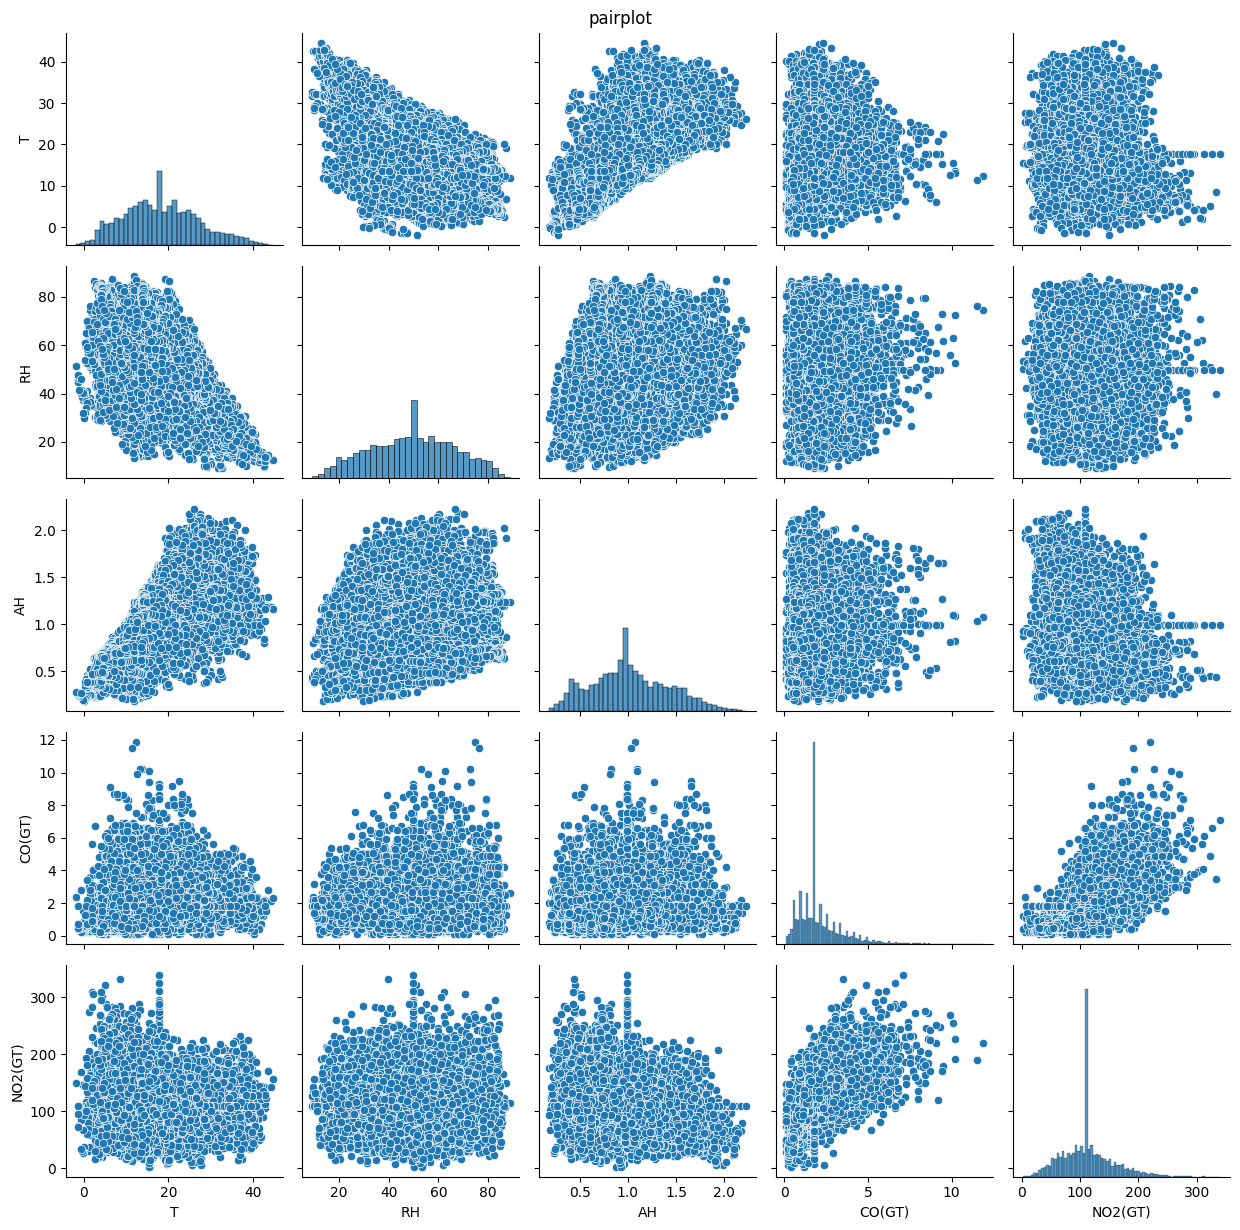

час побудови pairplot: 3.6578 c


In [282]:
# == pandas ==
start = time.time()
sns.pairplot(df[['T', 'RH', 'AH', 'CO(GT)', 'NO2(GT)']])
plt.suptitle("pairplot")
plt.tight_layout()
plt.show()
end = time.time()

print(f"{end - start:.4f} c")

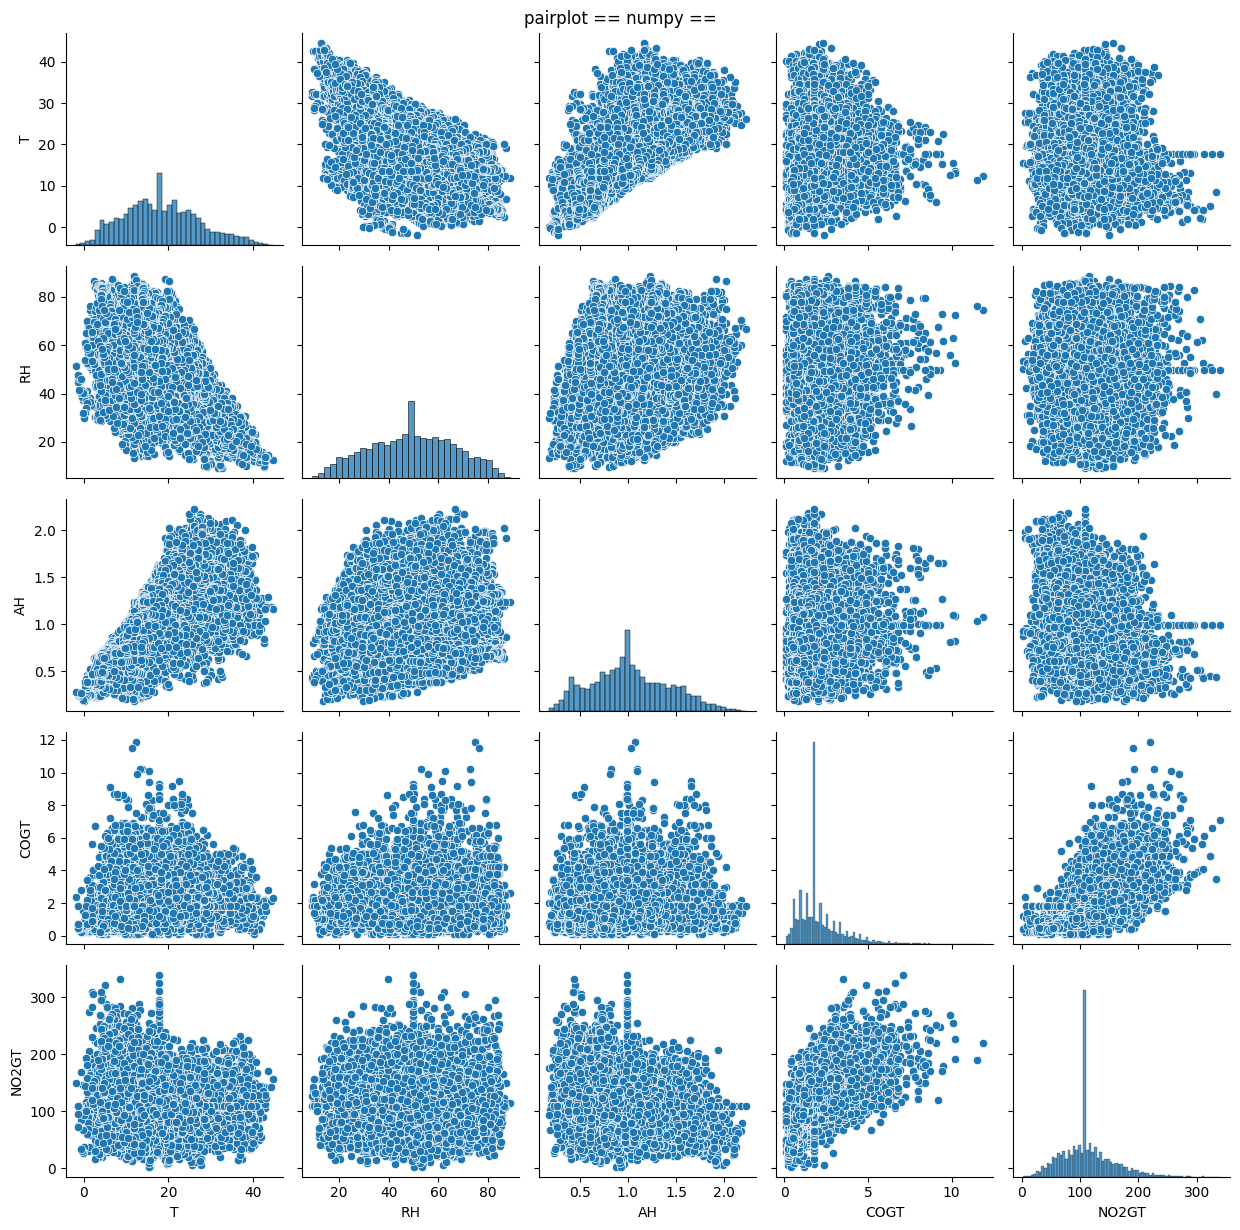

3.7655 c


In [287]:
start_np = time.time()
sns.pairplot(pd.DataFrame(arr[['T', 'RH', 'AH', 'COGT', 'NO2GT']]))
plt.suptitle("pairplot == numpy ==")
plt.tight_layout()
plt.show()

end_np = time.time()
print(f"{end_np - start_np:.4f} c")


Додаткове завдання

In [ ]:
X_pandas = df[['T']]
y_pandas = df['CO(GT)']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pandas, y_pandas, test_size=0.5, random_state=42)


models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

mse_scores_pandas = {}

plt.figure(figsize=(10, 6))
plt.scatter(X_test_p, y_test_p, color='black', label='Тестові дані')

for name, model in models.items():
    model.fit(X_train_p, y_train_p)
    y_pred = model.predict(X_test_p)
    mse = mean_squared_error(y_test_p, y_pred)
    mse_scores_pandas[name] = mse
    plt.plot(X_test_p, y_pred, label=f"{name} (MSE={mse:.4f})")

plt.xlabel("T")
plt.ylabel("CO(GT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("=== pandas === \nMSE для моделей")
for model, score in mse_scores_pandas.items():
    print(f"{model}: {score:.4f}")

best_model_pandas = min(mse_scores_pandas, key=mse_scores_pandas.get)
print(f"Найкраща модель : {best_model_pandas}")


In [ ]:
X_numpy = arr[:, df.columns.get_loc('T')].reshape(-1, 1)
y_numpy = arr[:, df.columns.get_loc('CO(GT)')]

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_numpy, y_numpy, test_size=0.5, random_state=42)


mse_scores_numpy = {}

plt.figure(figsize=(10, 6))
plt.scatter(X_test_n, y_test_n, color='black', label='Тестові дані')

for name, model in models.items():
    model.fit(X_train_n, y_train_n)
    y_pred = model.predict(X_test_n)
    mse = mean_squared_error(y_test_n, y_pred)
    mse_scores_numpy[name] = mse
    plt.plot(X_test_n, y_pred, label=f"{name} (MSE={mse:.4f})")

plt.xlabel("T")
plt.ylabel("CO(GT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("=== numpy === \nMSE для моделей")
for model, score in mse_scores_numpy.items():
    print(f"{model}: {score:.4f}")

best_model_numpy = min(mse_scores_numpy, key=mse_scores_numpy.get)
print(f"Найкраща модель: {best_model_numpy}")
